In [5]:
#%%writefile rematch_df.py
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.style.use('ggplot')


import build_financial_df as fin
import build_results_df as res
import merge_df as mer

# get top 2 candidates from each race, leaving 13212 candidates total
# this step simplifies, but reduces info about third party candidates
top2_cand = mer.merge_df_cut.groupby('elec_id')['vote%'].nlargest(2)
# top2_cand is a pd.Series double-indexed by new_elec_id & merge_df_cut index no.


# make dictionary with values equal to set of names of top 2 candidates 
cand_pair_dct = {}
for pair in top2_cand.index:
    l_name = mer.merge_df_cut.loc[pair[1], 'last_name']
    if pair[0] not in cand_pair_dct:
        cand_pair_dct[pair[0]] = set()
    cand_pair_dct[pair[0]].add(l_name)

# list of sets of rematch races
from itertools import chain
rev_dict = {}
for key, value in cand_pair_dct.items():
    rev_dict.setdefault(str(value), set()).add(key)
rematch_list = [values for key, values in rev_dict.items() if len(values) > 1]

rematch_elec_id = []
for i in rematch_list:
    for x in i:
        rematch_elec_id.append(x)
        
# create dataframe of the 13212 'candidate entries' (bear in mind each candidate is in there at least twice)
index_list = [top2_cand.index[i][1] for i in range(len(top2_cand))]
rematch_df_start = mer.merge_df_start[mer.merge_df_start['elec_id'].isin(rematch_elec_id)]

'''

#use this to see how many races remain in dataset; this should be 
count_ttl = 0
for each in rematch_list:
    x = len(each)
    count_ttl += x
count_ttl
# first attempt, count_ttl is 1324
# second attempt, count_ttl is 1295... this makes sense because 

'''

rematch_cut = rematch_df_start[['FEC_ID','elec_id','year', 'candidate', 'candidatevotes', 
                                'vote%', 'office', 'party', 'state', 'district','INC_STATUS',
                                'totalvotes', 'TTL_RECEIPTS', 'TTL_DISB']]

for i in range(len(rematch_list)):
    a = rematch_cut[rematch_cut['elec_id']==list(rematch_list[i])[0]].sort_values('FEC_ID').reset_index()
    b = rematch_cut[rematch_cut['elec_id']==list(rematch_list[i])[1]].sort_values('FEC_ID').reset_index()
    i1 = a['index'][0]
    i2 = a['index'][1]
    i3 = b['index'][0]
    i4 = b['index'][1]
    a.set_index('candidate')
    b.set_index('candidate')
    #print(a)
    #print(i1, i2, i3, i4)
    
    x = b['vote%']-a['vote%']
    # delta_vote for cand-idx0 in election a
    rematch_cut.loc[i1, 'delta_vote'] = 0
    # delta_vote for cand-idx1 in election a
    rematch_cut.loc[i2, 'delta_vote'] = 0
    # delta_vote for cand-idx0 in election b
    rematch_cut.loc[i3, 'delta_vote'] = x[0]
    # delta_vote for cand-idx1 in election b
    rematch_cut.loc[i4, 'delta_vote'] = x[1] 
    #print(x)
    
    y = b['TTL_DISB']-a['TTL_DISB']
    z = (b['TTL_DISB']-a['TTL_DISB'])/a['TTL_DISB']
    # delta_spend for cand-idx0 in election a
    rematch_cut.loc[i1, 'delta_spend'] = 0
    rematch_cut.loc[i1, 'delta_spend_%'] = 1
    # delta_spend for cand-idx1 in election a
    rematch_cut.loc[i2, 'delta_spend'] = 0
    rematch_cut.loc[i2, 'delta_spend_%'] = 1
    # delta_spend for cand-idx0 in election b
    rematch_cut.loc[i3, 'delta_spend'] = y[0]
    rematch_cut.loc[i3, 'delta_spend_%'] = z[0]
    # delta_spend for cand-idx1 in election b
    rematch_cut.loc[i4, 'delta_spend'] = y[1]
    rematch_cut.loc[i4, 'delta_spend_%'] = z[1] 
    
    w1 = a['vote%'][1]-a['vote%'][0]
    w2 = b['vote%'][1]-b['vote%'][0]
    # point_gap for cand-idx0 in election a
    rematch_cut.loc[i1, 'point_gap'] = w1*-1
    # point_gap for cand-idx1 in election a
    rematch_cut.loc[i2, 'point_gap'] = w1
    # point_gap for cand-idx0 in election b
    rematch_cut.loc[i3, 'point_gap'] = w2*-1
    # point_gap for cand-idx1 in election b
    rematch_cut.loc[i4, 'point_gap'] = w2 
    
    
rematch3 = rematch_cut[(~rematch_cut['delta_spend'].isna()) & (~rematch_cut['delta_vote'].isna())]
rematch_df = rematch3[rematch3['delta_vote']!= 0]
rematch_df
#I expected 1374; I got 1208 entries 
# missing 166

/Users/Kelly/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Kelly/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,FEC_ID,elec_id,year,candidate,candidatevotes,vote%,office,party,state,district,INC_STATUS,totalvotes,TTL_RECEIPTS,TTL_DISB,delta_vote,delta_spend,delta_spend_%,point_gap
402,S8MN00024,1990-MN-SE,1990,Rudy Boschwitz,864375,47.81,US Senate,republican,Minnesota,statewide,I,1808045,6087588.00,6222333.00,40.83,6177669.00,138.314280,-2.63
403,S0MN00013,1990-MN-SE,1990,Paul David Wellstone,911999,50.44,US Senate,democrat,Minnesota,statewide,C,1808045,1401706.00,1380560.00,0.12,-4598664.00,-0.769107,2.63
415,S0NC00111,1990-NC-SE,1990,Harvey B. Gantt,981573,47.43,US Senate,democrat,North Carolina,statewide,NaN,2069585,7856827.00,7808470.00,1.51,-198796.00,-0.024827,-5.11
416,S8NC00015,1990-NC-SE,1990,Jesse Helms,1087331,52.54,US Senate,republican,North Carolina,statewide,I,2069585,13376425.00,13425121.00,-0.10,5628646.00,0.721948,5.11
512,S4VT00017,1992-VT-SE,1992,Patrick J. Leahy,154762,54.16,US Senate,democrat,Vermont,statewide,I,285739,935503.00,991831.00,-18.06,-17893.00,-0.017721,10.81
513,S2VT00110,1992-VT-SE,1992,James H. Douglas,123854,43.35,US Senate,republican,Vermont,statewide,NaN,285739,196635.00,195737.00,41.39,195737.00,inf,-10.81
533,S0HI00084,1994-HI-SE,1994,Daniel K. Akaka,256189,71.78,US Senate,democrat,Hawaii,statewide,I,356902,622945.00,421356.00,-4.27,310866.00,2.813522,47.59
534,S8HI00012,1994-HI-SE,1994,Maria M. Hustace,86320,24.19,US Senate,republican,Hawaii,statewide,C,356902,29815.00,30272.00,2.47,-2067.00,-0.063917,-47.59
610,S6CO00135,1996-CO-SE,1996,Tom Strickland,667600,45.74,US Senate,democrat,Colorado,statewide,O,1459601,3313065.00,3294906.00,44.22,3134401.00,19.528370,-5.67
611,S6CO00168,1996-CO-SE,1996,Wayne Allard,750315,51.41,US Senate,republican,Colorado,statewide,O,1459601,2198131.00,2233429.00,49.94,2219146.00,155.369740,5.67


In [2]:
rematch_list

[{'1980-CA-09', '1982-CA-09'},
 {'1980-CA-11', '1982-CA-11'},
 {'1980-CA-36', '1982-CA-36', '1984-CA-36', '1988-CA-36'},
 {'1980-CA-37', '1992-CA-40', '1994-CA-40'},
 {'1980-CO-04', '2018-CA-44'},
 {'1980-CT-02', '1982-CT-02'},
 {'1980-CT-04', '1982-CT-04'},
 {'1980-IA-03', '1982-IA-03'},
 {'1980-IL-17', '1982-IL-04'},
 {'1980-IN-10', '1992-IN-02'},
 {'1980-KY-02', '1982-KY-02'},
 {'1980-MA-06', '1982-MA-06'},
 {'1980-MD-02', '1982-MD-02', '1984-MD-02'},
 {'1980-MN-07', '1982-MN-07'},
 {'1980-NC-04', '1994-NJ-01'},
 {'1980-NC-05', '1982-NC-05'},
 {'1980-NE-02', '1982-NE-02'},
 {'1980-NJ-03', '1982-NJ-03'},
 {'1980-OH-05', '1982-OH-05', '1984-OH-05'},
 {'1980-OH-06', '1992-OH-06'},
 {'1980-OH-14', '1982-OH-14'},
 {'1980-OK-01', '1982-OK-01'},
 {'1980-OK-04', '1982-OK-04'},
 {'1980-PA-08', '1982-PA-08'},
 {'1980-PA-15', '1988-PA-15'},
 {'1980-TN-03', '1982-TN-03'},
 {'1980-TX-13', '1982-TX-13'},
 {'1980-TX-21', '1984-TX-21'},
 {'1980-UT-01', '1986-UT-01', '1988-UT-01'},
 {'1980-WA-05', '

In [4]:
def get_rematch_table(idx):
    cand_rematch = mer.merge_df_cut[mer.merge_df_cut.loc[:, 'elec_id'].isin(rematch_list[idx])]
    return cand_rematch[['FEC_ID','elec_id','year', 'candidate', 'candidatevotes', 'office', 'party', 'state', 
                         'district','INC_STATUS','totalvotes', 'TTL_RECEIPTS', 'TTL_DISB']]

get_rematch_table(88)

,FEC_ID,elec_id,year,candidate,candidatevotes,office,party,state,district,INC_STATUS,totalvotes,TTL_RECEIPTS,TTL_DISB
3839,H0CA11022,1986-CA-11,1986,Tom Lantos,112380,US House,democrat,California,11,I,151695,299231.0,325435.0
3840,H6CA11011,1986-CA-11,1986,"G. M. ""Bill"" Quraishi",39315,US House,republican,California,11,NaN,151695,69374.0,63996.0
4562,H0CA11022,1988-CA-11,1988,Tom Lantos,145484,US House,democrat,California,11,I,205016,386453.0,269510.0
4563,H6CA11011,1988-CA-11,1988,"G. M. ""Bill"" Quraishi",50050,US House,republican,California,11,NaN,205016,90306.0,95575.0
5281,H6CA11011,1990-CA-11,1990,Bill Quraishi,45818,US House,republican,California,11,NaN,159365,97638.0,97030.0
5282,H0CA11022,1990-CA-11,1990,Tom Lantos,105029,US House,democrat,California,11,I,159365,788298.0,646730.0


In [ ]:

'''
# eventually want to check (and filter out) for weirdos where total vote % > 100%
sum_vote_percent = merge_df_cut.groupby('new_elec_id')['vote%'].nlargest(2).sum(level=0)
# below attempt didn't work
sum_percent_df = pd.DataFrame()
sum_percent_df = sum_vote_percent[sum_vote_percent<=100]
merge_df_cut2 = merge_df_cut[merge_df_cut['new_elec_id'].isin(sum_percent_df.reset_index()['index'])]
merge_df_cut2
'''



In [7]:
def all_f(z):
    return  0.000004776*z + 0.3114

Text(0, 0.5, 'Change in Vote Point')

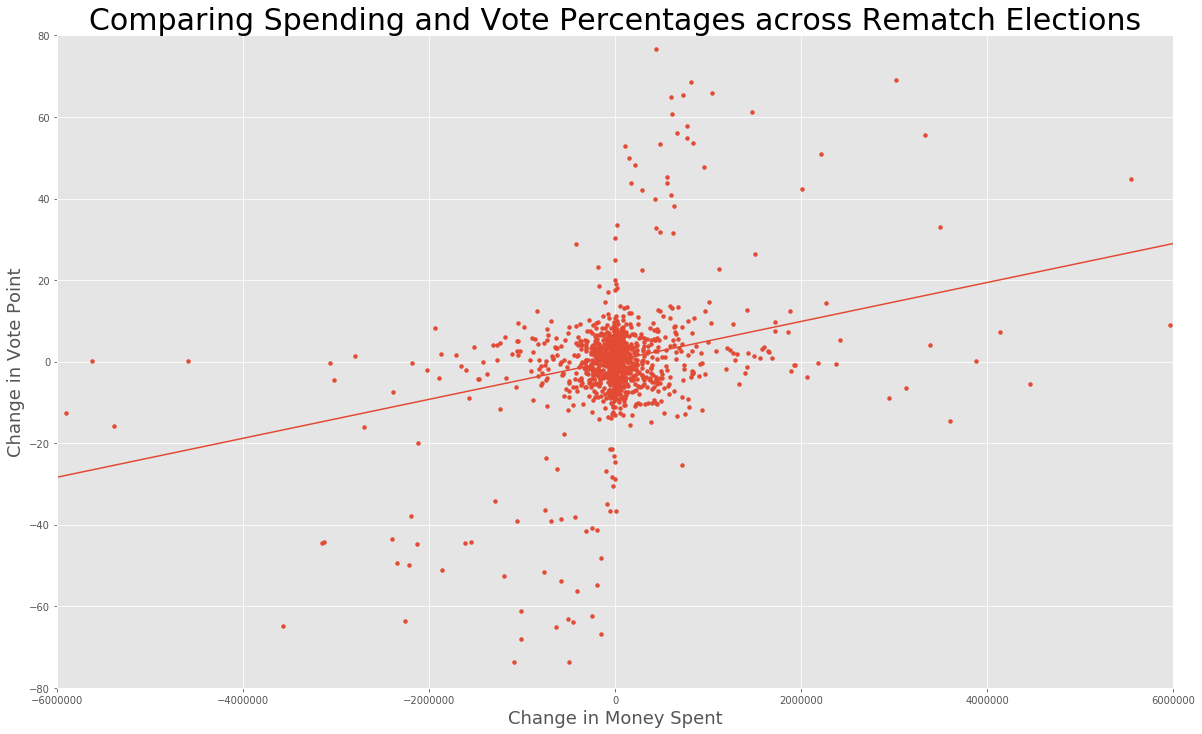

In [6]:
plot_all = rematch_df[['delta_vote', 'delta_spend']]
x = plot_all['delta_vote']
y = plot_all['delta_spend']
fig, ax = plt.subplots(1, figsize=(20,12))
z = np.linspace(-6000000, 6000000, num=1200)
ax.plot(z, all_f(z), '-')
ax.scatter(y, x, alpha=1, s=15)
ax.set_xlim(-6000000, 6000000)
ax.set_ylim(-80, 80)
ax.set_title('Comparing Spending and Vote Percentages across Rematch Elections', fontsize=30)
ax.set_xlabel('Change in Money Spent', fontsize=18)
ax.set_ylabel('Change in Vote Point', fontsize=18)

Text(0, 0.5, 'Change in Vote Point')

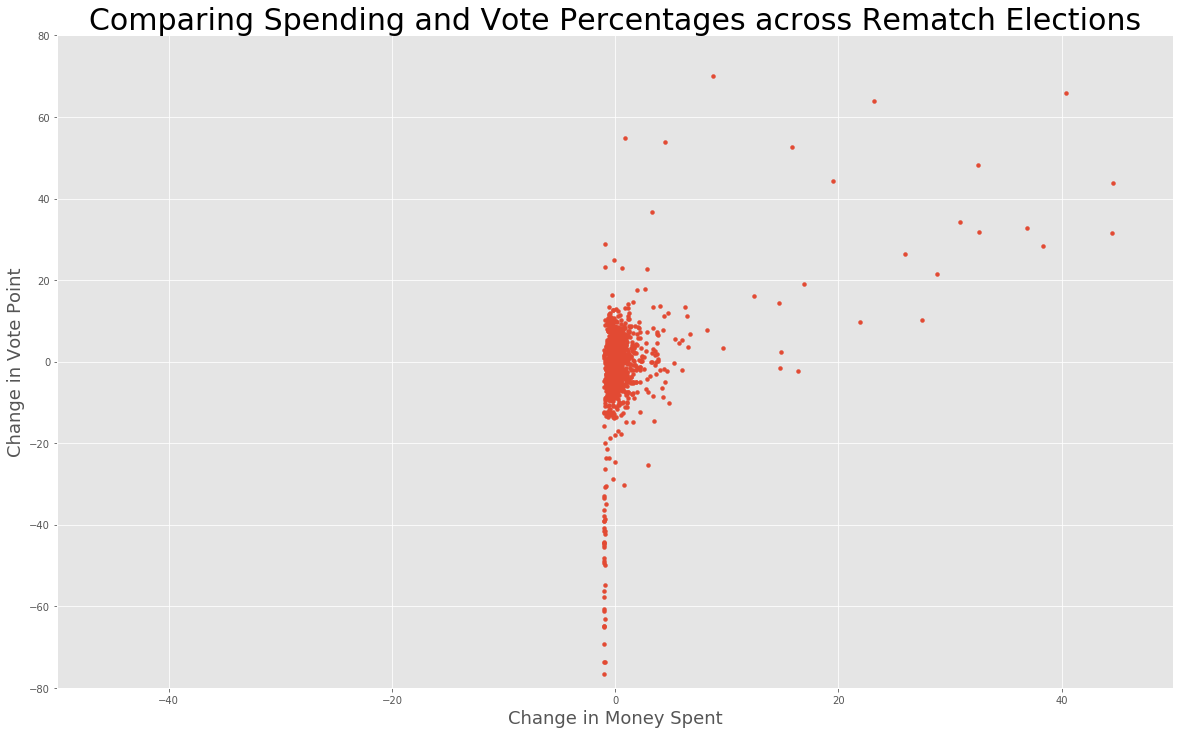

In [11]:
plot_all = rematch_df[['delta_vote', 'delta_spend_%']]
x = plot_all['delta_vote']
y = plot_all['delta_spend_%']
fig, ax = plt.subplots(1, figsize=(20,12))
#z = np.linspace(-6000000, 6000000, num=1200)
#ax.plot(z, all_f(z), '-')
ax.scatter(y, x, alpha=1, s=15)
ax.set_xlim(-50,50)
ax.set_ylim(-80, 80)
ax.set_title('Comparing Spending and Vote Percentages across Rematch Elections', fontsize=30)
ax.set_xlabel('Change in Money Spent', fontsize=18)
ax.set_ylabel('Change in Vote Point', fontsize=18)

In [13]:
import statsmodels.api as sm
df = rematch_df[['delta_vote', 'delta_spend']]
X = df['delta_spend']
y = df['delta_vote']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()
print("Coefficients:")
print(model.params, "\n")
print("P-values for coefficients:")
print(model.pvalues)

Coefficients:
const         -0.352495
delta_spend    0.000005
dtype: float64 

P-values for coefficients:
const          3.585665e-01
delta_spend    2.857020e-37
dtype: float64


In [7]:
rematch_GOP = rematch_df[rematch_df['party']=='republican']
rematch_Dem = rematch_df[rematch_df['party']=='democrat']
rematch_Ind = rematch_df[(rematch_df['party']!='democrat') & (rematch_df['party']!='republican')]

In [11]:
import statsmodels.api as sm
df_GOP = rematch_GOP[['delta_vote', 'delta_spend']]
X = df_GOP['delta_spend']
y = df_GOP['delta_vote']
X = sm.add_constant(X)
model_GOP = sm.OLS(y, X).fit()
predictions = model_GOP.predict(X)
model_GOP.summary()
print("Coefficients:")
print(model_GOP.params, "\n")
print("P-values for coefficients:")
print(model_GOP.pvalues)

Coefficients:
const          1.051698
delta_spend    0.000003
dtype: float64 

P-values for coefficients:
const          1.798204e-02
delta_spend    4.764405e-12
dtype: float64


In [12]:
import statsmodels.api as sm
df_Dem = rematch_Dem[['delta_vote', 'delta_spend']]
X = df_Dem['delta_spend']
y = df_Dem['delta_vote']
X = sm.add_constant(X)
model_Dem = sm.OLS(y, X).fit()
predictions = model_Dem.predict(X)
model_Dem.summary()
print("Coefficients:")
print(model_Dem.params, "\n")
print("P-values for coefficients:")
print(model_Dem.pvalues)

Coefficients:
const          1.342033
delta_spend    0.000005
dtype: float64 

P-values for coefficients:
const          3.447968e-03
delta_spend    4.230429e-13
dtype: float64


In [52]:
def Ind_f(x):
    return  model_Ind.params[1]*x + model_Ind.params[0]
def Dem_f(x):
    return  model_Dem.params[1]*x + model_Dem.params[0]
def GOP_f(x):
    return  model_GOP.params[1]*x + model_GOP.params[0]
def Y80_f(x):
    return  model_80s.params[1]*x + model_80s.params[0]
def Y90_f(x):
    return  model_90s.params[1]*x + model_90s.params[0]
def Y00_f(x):
    return  model_00s.params[1]*x + model_00s.params[0]
def Y10_f(x):
    return  model_10s.params[1]*x + model_10s.params[0]

"\n#ax.tick_params(axis='x', pad=30) #move position of x-ticks and axis label\n\n"

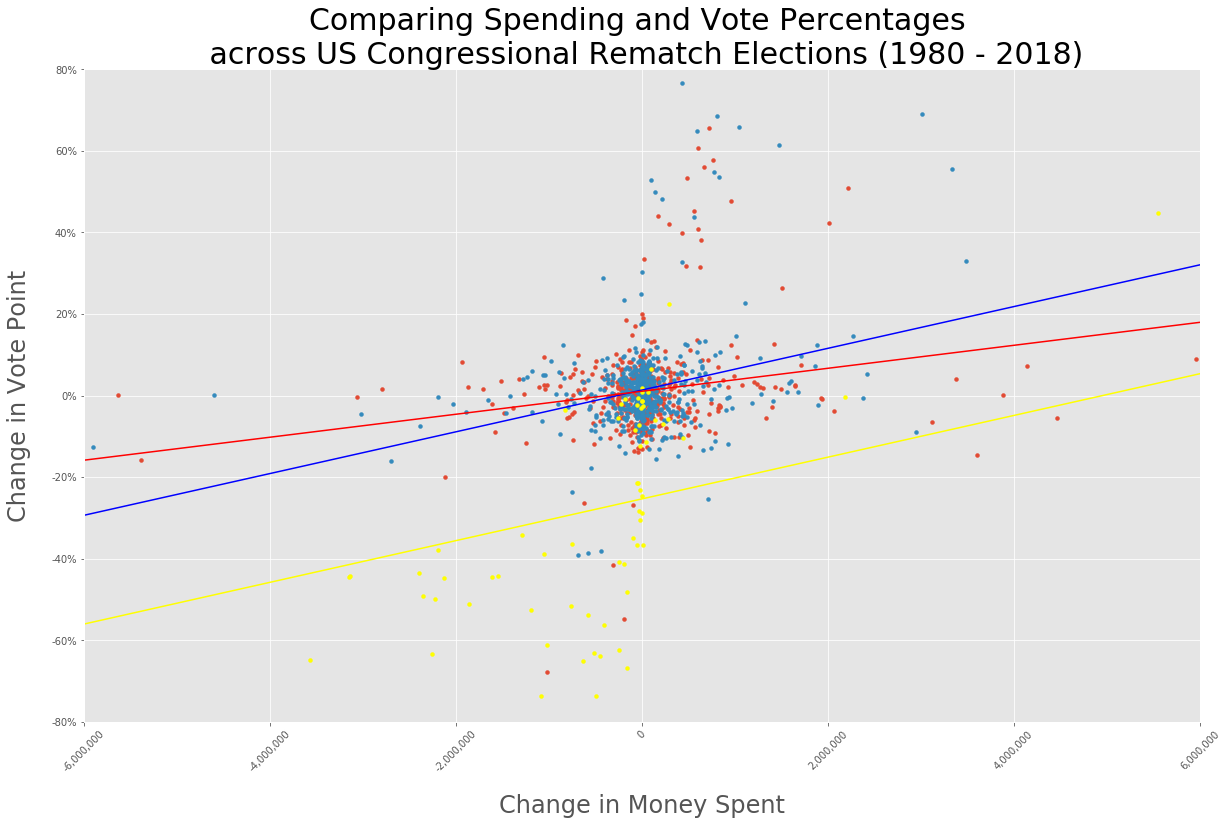

In [53]:
x1 = rematch_GOP['delta_vote']
y1 = rematch_GOP['delta_spend']
x2 = rematch_Dem['delta_vote']
y2 = rematch_Dem['delta_spend']
x3 = rematch_Ind['delta_vote']
y3 = rematch_Ind['delta_spend']

x = np.linspace(-6000000, 6000000, num=1200)

fig, ax = plt.subplots(1, figsize=(20,12))
ax.scatter(y1, x1, alpha=1, s=15)
ax.scatter(y2, x2, alpha=1, s=15)
ax.scatter(y3, x3, color='yellow', alpha=1, s=15)

# plot Ind line
ax.plot(x, Ind_f(x), '-', color='yellow')

# plot Dem line
ax.plot(x, Dem_f(x), '-', color='blue')

# plot GOP line
ax.plot(x, GOP_f(x), '-', color='red')


ax.set_xlim(-6000000, 6000000)
ax.set_ylim(-80, 80)
ax.set_title('Comparing Spending and Vote Percentages \n across US Congressional Rematch Elections (1980 - 2018)', fontsize=30)
ax.set_xlabel('Change in Money Spent', fontsize=24)
ax.set_ylabel('Change in Vote Point', fontsize=24)
ax.xaxis.labelpad = 20 #move position of x-axis label, but not x ticks
ax.yaxis.labelpad = 20 #move position of x-axis label (but not y ticks)

#must add: import matplotlib.ticker as ticker
#
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

### next three lines make y labels into percentages
vals = ax.get_yticks()
percents = [x/100 for x in vals] #if already in decimal format, skip this
ax.set_yticklabels(['{:,.0%}'.format(x) for x in percents])

plt.xticks(rotation=45) #rotate x labels


'''
#ax.tick_params(axis='x', pad=30) #move position of x-ticks and axis label

'''

In [10]:
import statsmodels.api as sm
df_Ind = rematch_Ind[['delta_vote', 'delta_spend']]
X = df_Ind['delta_spend']
y = df_Ind['delta_vote']
X = sm.add_constant(X)
model_Ind = sm.OLS(y, X).fit()
predictions = model_Ind.predict(X)
model_Ind.summary()
print("Coefficients:")
print(model_Ind.params, "\n")
print("P-values for coefficients:")
print(model_Ind.pvalues)

Coefficients:
const         -25.349611
delta_spend     0.000005
dtype: float64 

P-values for coefficients:
const          1.004543e-11
delta_spend    2.620220e-04
dtype: float64


In [40]:
rematch_80s = rematch_df[rematch_df['year']<1990]
rematch_90s = rematch_df[(rematch_df['year']<2000) & (rematch_df['year']>1989)]
rematch_00s = rematch_df[(rematch_df['year']<2010) & (rematch_df['year']>1999)]
rematch_10s = rematch_df[rematch_df['year']>2009]

(array([-6000000., -4000000., -2000000.,        0.,  2000000.,  4000000.,
         6000000.]), <a list of 7 Text xticklabel objects>)

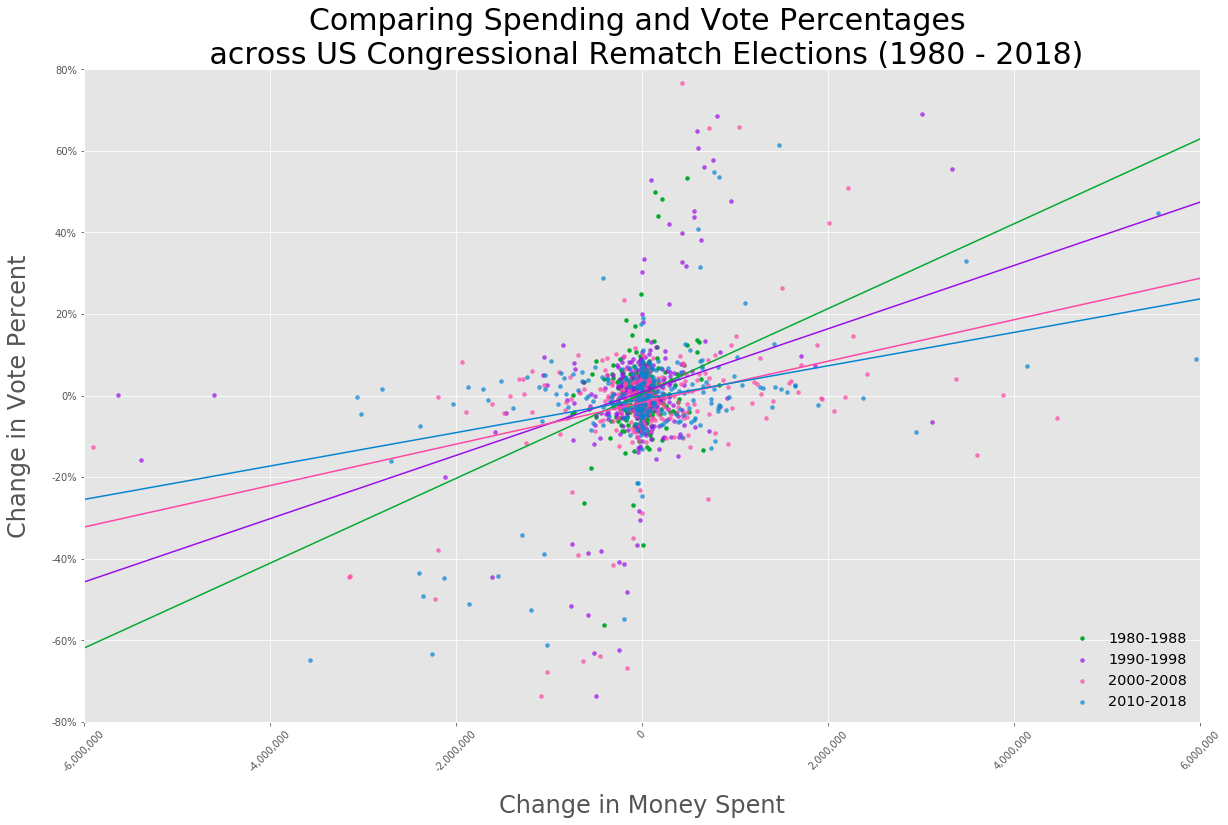

In [80]:
fig, ax = plt.subplots(1, figsize=(20,12))
ax.scatter(rematch_80s['delta_spend'], rematch_80s['delta_vote'], alpha=1, s=15, color='#02ab2e', label='1980-1988')
ax.scatter(rematch_90s['delta_spend'], rematch_90s['delta_vote'], alpha=.7, s=15, color='#9a0eea', label='1990-1998')
ax.scatter(rematch_00s['delta_spend'], rematch_00s['delta_vote'], alpha=.7, s=15, color='#fe46a5', label='2000-2008')
ax.scatter(rematch_10s['delta_spend'], rematch_10s['delta_vote'], alpha=.7, s=15, color='#0485d1', label='2010-2018')

# plot 80s line
ax.plot(x, Y80_f(x), '-', color='#02ab2e')
# plot 90s line
ax.plot(x, Y90_f(x), '-', color='#9a0eea')
# plot 00s line
ax.plot(x, Y00_f(x), '-', color='#fe46a5')
# plot 10s line
ax.plot(x, Y10_f(x), '-', color='#0485d1')

ax.legend(loc='lower right', frameon=False, fontsize='x-large')


ax.set_xlim(-6000000, 6000000)
ax.set_ylim(-80, 80)
ax.set_title('Comparing Spending and Vote Percentages \n across US Congressional Rematch Elections (1980 - 2018)', fontsize=30)
ax.set_xlabel('Change in Money Spent', fontsize=24)
ax.set_ylabel('Change in Vote Percent', fontsize=24)
ax.xaxis.labelpad = 20 #move position of x-axis label, but not x ticks
ax.yaxis.labelpad = 20 #move position of x-axis label (but not y ticks)



#must add: import matplotlib.ticker as ticker
#
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

### next three lines make y labels into percentages
vals = ax.get_yticks()
percents = [x/100 for x in vals] #if already in decimal format, skip this
ax.set_yticklabels(['{:,.0%}'.format(x) for x in percents])

plt.xticks(rotation=45) #rotate x labels

### 80s lin reg

In [43]:
import statsmodels.api as sm
df_80s = rematch_80s[['delta_vote', 'delta_spend']]
X = df_80s['delta_spend']
y = df_80s['delta_vote']
X = sm.add_constant(X)
model_80s = sm.OLS(y, X).fit()
predictions = model_80s.predict(X)
model_80s.summary()
print("Coefficients:")
print(model_80s.params, "\n")
print("P-values for coefficients:")
print(model_80s.pvalues)

Coefficients:
const          0.481178
delta_spend    0.000010
dtype: float64 

P-values for coefficients:
const          0.406613
delta_spend    0.000115
dtype: float64


In [45]:
import statsmodels.api as sm
df_90s = rematch_90s[['delta_vote', 'delta_spend']]
X = df_90s['delta_spend']
y = df_90s['delta_vote']
X = sm.add_constant(X)
model_90s = sm.OLS(y, X).fit()
predictions = model_90s.predict(X)
model_90s.summary()
print("Coefficients:")
print(model_90s.params, "\n")
print("P-values for coefficients:")
print(model_90s.pvalues)

Coefficients:
const          0.834992
delta_spend    0.000008
dtype: float64 

P-values for coefficients:
const          3.108551e-01
delta_spend    7.265630e-12
dtype: float64


In [47]:
import statsmodels.api as sm
df_00s = rematch_00s[['delta_vote', 'delta_spend']]
X = df_00s['delta_spend']
y = df_00s['delta_vote']
X = sm.add_constant(X)
model_00s = sm.OLS(y, X).fit()
predictions = model_00s.predict(X)
model_00s.summary()
print("Coefficients:")
print(model_00s.params, "\n")
print("P-values for coefficients:")
print(model_00s.pvalues)

Coefficients:
const         -1.752814
delta_spend    0.000005
dtype: float64 

P-values for coefficients:
const          2.045015e-02
delta_spend    6.715596e-09
dtype: float64


In [48]:
import statsmodels.api as sm
df_10s = rematch_10s[['delta_vote', 'delta_spend']]
X = df_10s['delta_spend']
y = df_10s['delta_vote']
X = sm.add_constant(X)
model_10s = sm.OLS(y, X).fit()
predictions = model_10s.predict(X)
model_10s.summary()
print("Coefficients:")
print(model_10s.params, "\n")
print("P-values for coefficients:")
print(model_10s.pvalues)

Coefficients:
const         -0.901968
delta_spend    0.000004
dtype: float64 

P-values for coefficients:
const          2.633891e-01
delta_spend    3.830163e-17
dtype: float64


In [ ]:
rematch_close = rematch_df[rematch_df['point']=='republican']